In [ ]:
import random
import pandas as pd
import numpy as np
import os
import scipy.sparse as sparse
import pickle
from scipy.sparse.linalg import spsolve
from sklearn.preprocessing import MinMaxScaler

data_path = '../data/'

In [58]:
interaction = pd.read_csv(os.path.join(data_path, 'interaction.csv'))
with open(os.path.join(data_path, "song_to_num.pickle"), "rb") as file:
    song_to_num = pickle.load(file)
    
with open(os.path.join(data_path, "num_to_song.pickle"), "rb") as file:
    num_to_song = pickle.load(file)

In [60]:
interaction

,user_id,song_id,plays
0,0,34,3
1,0,284,13
2,0,985,3
3,0,1747,11
4,0,1829,4
...,...,...,...
939568,11073,22238,9
939569,11073,22386,3
939570,11073,22551,7
939571,11073,22606,8


In [191]:
import random
import pandas as pd
import numpy as np

import scipy.sparse as sparse
from scipy.sparse.linalg import spsolve
from sklearn.preprocessing import MinMaxScaler

 # Create lists of all users, songs and plays
users = list(np.sort(interaction.user_id.unique()))
songs = list(np.sort(interaction.song_id.unique()))
plays = list(interaction.plays)

# Get the rows and columns for our new matrix
rows = interaction.user_id.astype(int)
cols = interaction.song_id.astype(int)

# Contruct a sparse matrix for our users and items containing number of plays
data_sparse = sparse.csr_matrix((plays, (rows, cols)), shape=(len(users), max(songs)+1))

In [102]:
item_lookup = pd.DataFrame({'song_id' : num_to_song.keys(), 'song' : song_to_num.keys()})

In [214]:
def recommend(user_id, data_sparse, user_vecs, item_vecs, item_lookup=None, num_items=10):
  
    # Get all interactions by the user
    user_interactions = data_sparse[user_id,:].toarray()

    # We don't want to recommend items the user has consumed. So let's
    # set them all to 0 and the unknowns to 1.
    user_interactions = user_interactions.reshape(-1) + 1 #Reshape to turn into 1D array
    user_interactions[user_interactions > 1] = 0

    # This is where we calculate the recommendation by taking the 
    # dot-product of the user vectors with the item vectors.
    rec_vector = user_vecs[user_id,:].dot(item_vecs.T).toarray()

    # Let's scale our scores between 0 and 1 to make it all easier to interpret.
    min_max = MinMaxScaler()
    rec_vector_scaled = min_max.fit_transform(rec_vector.reshape(-1,1))[:,0]
    recommend_vector = user_interactions*rec_vector_scaled
   
    # Get all the artist indices in order of recommendations (descending) and
    # select only the top "num_items" items. 
    item_idx = np.argsort(recommend_vector)[::-1][:num_items]

    songs = []
    scores = []

    # Loop through our recommended artist indicies and look up the actial artist name
    for idx in item_idx:
        # songs.append(item_lookup.song.loc[item_lookup.song_id == idx].iloc[0])
        songs.append(idx)
        scores.append(recommend_vector[idx])

    # Create a new dataframe with recommended artist names and scores
    recommendations = pd.DataFrame({'song': songs, 'score': scores})
    
    return recommendations

In [109]:
user_id = 3

#------------------------------
# GET ITEMS CONSUMED BY USER
#------------------------------

# Let's print out what the user has listened to
consumed_idx = data_sparse[user_id,:].nonzero()[1]
consumed_items = item_lookup.loc[item_lookup.song_id.isin(consumed_idx)]
# print(consumed_items)

# Let's generate and print our recommendations
recommendations = recommend(user_id, data_sparse, user_vecs, item_vecs)
print(recommendations)

    song     score
0  11252  1.000000
1  35019  0.975683
2  25764  0.952084
3  38897  0.945581
4  28775  0.942772
5   9717  0.938491
6  32207  0.935176
7  24927  0.934764
8   9211  0.929931
9   9289  0.928855


In [142]:
def get_user_songs(user_num, matrix, num_items, user_vecs, item_vecs, item_lookup):
    user_song_dict = dict()
    for i in range(user_num):
        recommendations = recommend(i, matrix, user_vecs, item_vecs, item_lookup, num_items=num_items)
        user_song_dict[i] = list(recommendations['song'])
    return user_song_dict

In [171]:
def evaluate_recall(user_song_dict, valid_dataset, user_num):
    correct = 0
    like_cnt = 0
    recall = 0
    cnt = 0
    for i in range(user_num):
        try:
            real_answer = valid_dataset[i]
            predicted_answer = user_song_dict[i]
            correct_num = len(set(real_answer) & set(predicted_answer))
            # correct += correct_num
            # like_cnt += len(real_answer)
            user_recall = correct_num / len(real_answer)
            recall += user_recall
            cnt += 1
        except:
            pass
    return recall / cnt
    # return correct / like_cnt

In [188]:
def implicit_als(sparse_data, alpha_val=40, iterations=10, lambda_val=0.1, features=10):
    
    confidence = sparse_data * alpha_val
    
    # Get the size of user rows and item columns
    user_size, item_size = sparse_data.shape
    
    # We create the user vectors X of size users-by-features, the item vectors
    # Y of size items-by-features and randomly assign the values.
    X = sparse.csr_matrix(np.random.normal(size = (user_size, features)))
    Y = sparse.csr_matrix(np.random.normal(size = (item_size, features)))
    
    #Precompute I and lambda * I
    X_I = sparse.eye(user_size)
    Y_I = sparse.eye(item_size)
    
    I = sparse.eye(features)
    lI = lambda_val * I
    recall_at_10_list = list()
    recall_at_20_list = list()
    recall_at_50_list = list()

    for i in range(iterations):
        print('iteration %d of %d' % (i+1, iterations))
        
        # Precompute Y-transpose-Y and X-transpose-X
        yTy = Y.T.dot(Y)
        xTx = X.T.dot(X)

        # Loop through all users
        for u in range(user_size):

            # Get the user row.
            u_row = confidence[u,:].toarray() 

            # Calculate the binary preference p(u)
            p_u = u_row.copy()
            p_u[p_u != 0] = 1.0

            # Calculate Cu and Cu - I
            CuI = sparse.diags(u_row, [0])
            Cu = CuI + Y_I

            # Put it all together and compute the final formula
            yT_CuI_y = Y.T.dot(CuI).dot(Y)
            yT_Cu_pu = Y.T.dot(Cu).dot(p_u.T)
            X[u] = spsolve(yTy + yT_CuI_y + lI, yT_Cu_pu)

    
        for i in range(item_size):

            # Get the item column and transpose it.
            i_row = confidence[:,i].T.toarray()

            # Calculate the binary preference p(i)
            p_i = i_row.copy()
            p_i[p_i != 0] = 1.0

            # Calculate Ci and Ci - I
            CiI = sparse.diags(i_row, [0])
            Ci = CiI + X_I

            # Put it all together and compute the final formula
            xT_CiI_x = X.T.dot(CiI).dot(X)
            xT_Ci_pi = X.T.dot(Ci).dot(p_i.T)
            Y[i] = spsolve(xTx + xT_CiI_x + lI, xT_Ci_pi)
        
        user_vecs = X
        item_vecs = Y
        user_song_dict_10 = get_user_songs(11073, data_sparse, 10, user_vecs, item_vecs, item_lookup)
        recall_at_10 = evaluate_recall(user_song_dict_10, new_val, 11073)
        user_song_dict_20 = get_user_songs(11073, data_sparse, 20, user_vecs, item_vecs, item_lookup)
        recall_at_20 = evaluate_recall(user_song_dict_20, new_val, 11073)
        user_song_dict_50 = get_user_songs(11073, data_sparse, 50, user_vecs, item_vecs, item_lookup)
        recall_at_50 = evaluate_recall(user_song_dict_50, new_val, 11073)
        recall_at_10_list.append(recall_at_10)
        recall_at_20_list.append(recall_at_20)
        recall_at_50_list.append(recall_at_50)
        print(f'recall@10 : {recall_at_10}')
        print(f'recall@20 : {recall_at_20}')
        print(f'recall@50 : {recall_at_50}')

    eval_data = dict()
    eval_data['at_10'] = recall_at_10_list
    eval_data['at_20'] = recall_at_20_list
    eval_data['at_50'] = recall_at_50_list
    
    return X, Y, eval_data

In [192]:
user_vecs, item_vecs, eval_data = implicit_als(data_sparse, iterations=10, features=20, alpha_val=20)

iteration 1 of 10
recall@10 : 0.015758673381752616
recall@20 : 0.0234570704598881
recall@50 : 0.04031667252759393
iteration 2 of 10
recall@10 : 3.1674681738306536e-05
recall@20 : 0.0001977700237107618
recall@50 : 0.0008060381719716386
iteration 3 of 10
recall@10 : 0.046096720835805426
recall@20 : 0.07020849421936932
recall@50 : 0.12450028893536376
iteration 4 of 10
recall@10 : 0.010756541108576061
recall@20 : 0.018794285577798223
recall@50 : 0.04591442703791238
iteration 5 of 10
recall@10 : 0.045932443865907474
recall@20 : 0.07544214927498187
recall@50 : 0.141499790177302
iteration 6 of 10
recall@10 : 0.02423160396603728
recall@20 : 0.04291217125534657
recall@50 : 0.09144758187859992
iteration 7 of 10
recall@10 : 0.04370015871928584
recall@20 : 0.07285523573524702
recall@50 : 0.14052750063121036
iteration 8 of 10
recall@10 : 0.027097721228801618
recall@20 : 0.05129012890750036
recall@50 : 0.1079113131772002
iteration 9 of 10
recall@10 : 0.03600464435232423
recall@20 : 0.064577206565962

In [ ]:
with open('user_vecs.pkl', 'wb') as f:
    pickle.dump(user_vecs, f)
with open('item_vecs.pkl', 'wb') as f:
    pickle.dump(item_vecs, f)
with open('data_sparse.pkl', 'wb') as f:
    pickle.dump(data_sparse, f)

In [200]:
new_eval_data = dict()
new_eval_data['Iteration'] = [1,3,5,7]
new_eval_data['Recall@10'] = [0.015758673381752616,
 0.046096720835805426,
 0.045932443865907474,
 0.04370015871928584]
new_eval_data['Recall@20'] = [0.0234570704598881,
 0.07020849421936932,
 0.07144214927498187,
 0.07285523573524702]
new_eval_data['Recall@50'] = [0.04031667252759393,
 0.12450028893536376,
 0.131499790177302,
 0.14052750063121036]

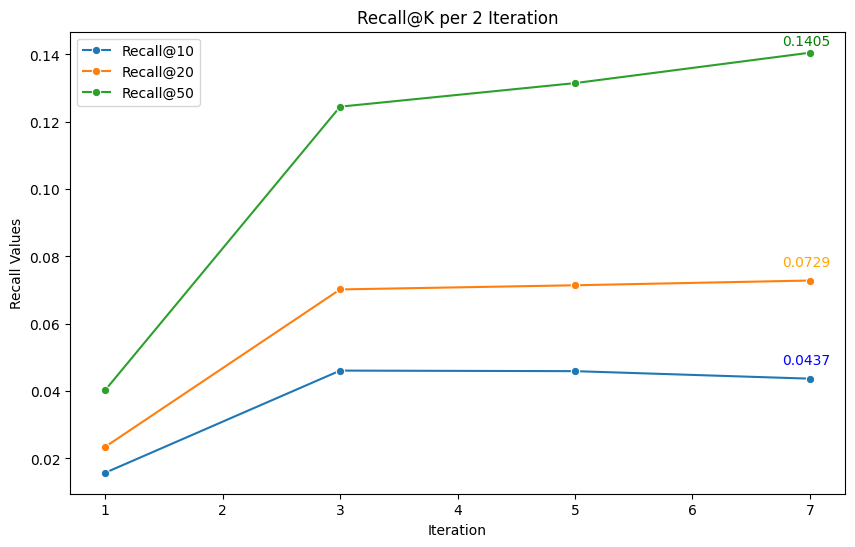

In [209]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.DataFrame(new_eval_data)

plt.figure(figsize=(10, 6))
sns.lineplot(x='Iteration', y='Recall@10', data=df, marker='o', label='Recall@10')
sns.lineplot(x='Iteration', y='Recall@20', data=df, marker='o', label='Recall@20')
sns.lineplot(x='Iteration', y='Recall@50', data=df, marker='o', label='Recall@50')
plt.xlabel('Iteration')
plt.ylabel('Recall Values')
plt.title('Recall@K per 2 Iteration')
last_iteration = df['Iteration'].iloc[-1]
last_recall_at_10 = df['Recall@10'].iloc[-1]
last_recall_at_20 = df['Recall@20'].iloc[-1]
last_recall_at_50 = df['Recall@50'].iloc[-1]
plt.annotate(f"{last_recall_at_10:.4f}", (last_iteration, last_recall_at_10), xytext=(-20, 10), textcoords='offset points', color='blue')
plt.annotate(f"{last_recall_at_20:.4f}", (last_iteration, last_recall_at_20), xytext=(-20, 10), textcoords='offset points', color='orange')
plt.annotate(f"{last_recall_at_50:.4f}", (last_iteration, last_recall_at_50), xytext=(-20, 5), textcoords='offset points', color='green')
plt.legend()
plt.show()